In [2]:
import os
import torch
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from constant import EXPS_PATH, DB_PATH
from lib import load_json

# disable warnings
warnings.filterwarnings('ignore')

# torch version
print(torch.__version__)

2.3.0+cu121


In [2]:
dataset = 'adult'
methods = [
    'codi',
    'fair-smote',
    'fair-tab-ddpm',
    'fair-tab-gan',
    # 'goggle',
    'great',
    'smote',
    'stasy',
    'tabddpm',
    # 'tabsyn',
]

In [3]:
def read_score(dataset, method, exp_dir=EXPS_PATH):
    exp_dir = os.path.join(exp_dir, dataset, method)
    
    # if best exists use it otherwise use many-exps
    best_exp_dir = os.path.join(exp_dir, 'best')
    if os.path.exists(best_exp_dir):
        exp_dir = best_exp_dir
    else:
        exp_dir = os.path.join(exp_dir, 'many-exps')
    
    score_file = os.path.join(exp_dir, 'metric.json')
    score = load_json(score_file)
    return score

In [4]:
read_score(dataset, 'codi')

{'CatBoost': [0.8452744385802621, 0.008282790545036436]}

In [5]:
# read all scores
scores = {}
for method in methods:
    scores[method] = read_score(dataset, method)

In [6]:
scores

{'codi': {'CatBoost': [0.8452744385802621, 0.008282790545036436]},
 'fair-smote': {'CatBoost': [0.907525586183441, 0.0012483818714813146]},
 'fair-tab-ddpm': {'CatBoost': [0.8918966734489052, 0.0009141151834793541]},
 'fair-tab-gan': {'CatBoost': [0.8963132044906436, 0.0023986151127191363]},
 'great': {'CatBoost': [0.9151733240945673, 0.0015614463640945347]},
 'smote': {'CatBoost': [0.9240111484286359, 0.0003638549790596148]},
 'stasy': {'CatBoost': [0.8890867670152236, 0.0038861689251143937]},
 'tabddpm': {'CatBoost': [0.9053126278614677, 0.0011767087455055436]}}

Text(0, 0.5, 'Test AUC')

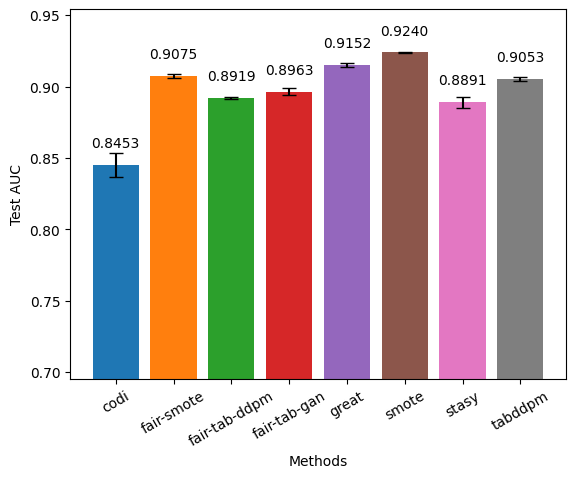

In [7]:
# box plot for all methods
fig, ax = plt.subplots()
for method, score in scores.items():
    mean = score['CatBoost'][0]
    std = score['CatBoost'][1]
    ax.bar(method, mean, yerr=std, capsize=5)
    
    # show values mean
    ax.text(method, mean + 0.01, f'{mean:.4f}', ha='center', va='bottom')

# rotate x labels
ax.set_xticklabels(methods, rotation=30, ha='center')

# set ylim
min_value = min([score['CatBoost'][0] for score in scores.values()])
max_value = max([score['CatBoost'][0] for score in scores.values()])
ax.set_ylim(min_value - 0.15, max_value + 0.03)

# set x and y labels
ax.set_xlabel('Methods')
ax.set_ylabel('Test AUC')

In [8]:
def evaluate_all_methods(dataset, methods, exps_path=EXPS_PATH):
    results = {}
    for method in methods:
        print(f'evaluating {method}...')
        exp_dir = os.path.join(exps_path, dataset, method, 'best')
        if not os.path.exists(exp_dir):
            exp_dir = os.path.join(exps_path, dataset, method, 'many-exps')
        
        result = evaluate_syn_data(
            os.path.join(DB_PATH, dataset),
            exp_dir,
            2024, 3, ['CatBoost'],
        )
        results[method] = result
    return results

In [9]:
results = evaluate_all_methods(dataset, methods)

evaluating codi...
evaluating fair-smote...
evaluating fair-tab-ddpm...
evaluating fair-tab-gan...
evaluating great...
evaluating smote...
evaluating stasy...
evaluating tabddpm...


In [13]:
results

{'codi': {'CatBoost': {'AUC': (0.8452744385802621, 0.008282790545036436),
   'DPR': (0.2977469329623258, 0.021138623321720843),
   'EOR': (0.2814875546818649, 0.024410727999117116)}},
 'fair-smote': {'CatBoost': {'AUC': (0.907525586183441, 0.0012483818714813146),
   'DPR': (0.26812189573730827, 0.005785909227049049),
   'EOR': (0.20953125369749379, 0.012551385499209974)}},
 'fair-tab-ddpm': {'CatBoost': {'AUC': (0.8918966734489052,
    0.0009141151834793541),
   'DPR': (0.643225937790688, 0.021503808329416976),
   'EOR': (0.7289239964952982, 0.009819257489331837)}},
 'fair-tab-gan': {'CatBoost': {'AUC': (0.8963132044906436,
    0.0023986151127191363),
   'DPR': (0.4504862317681316, 0.01839435470811548),
   'EOR': (0.5800302134557668, 0.04090673083367308)}},
 'great': {'CatBoost': {'AUC': (0.9151733240945673, 0.0015614463640945347),
   'DPR': (0.2607877887450787, 0.012551699844100974),
   'EOR': (0.20971573750492603, 0.02396696926173745)}},
 'smote': {'CatBoost': {'AUC': (0.924011148428

In [29]:
print('Results on Adult Dataset (Our Method vs Baselines)')
print('-------------------------------------------------------------------------------------')
for method, result in results.items():
    # method, auc: 4f +- 4f, dpr: 4f +- 4f, eor: 4f +- 4f
    if method == 'fair-tab-ddpm':
        continue
    n_slash = 15 - len(method)
    print(f'{method}{"-" * n_slash} AUC: {result["CatBoost"]["AUC"][0]:.4f} +- {result["CatBoost"]["AUC"][1]:.4f} | DPR: {result["CatBoost"]["DPR"][0]:.4f} +- {result["CatBoost"]["DPR"][1]:.4f} | EOR: {result["CatBoost"]["EOR"][0]:.4f} +- {result["CatBoost"]["EOR"][1]:.4f}')
    
print('-------------------------------------------------------------------------------------')
method = 'fair-tab-ddpm'
n_slash = 15 - len(method)
print(f'{method}{"-" * n_slash} AUC: {results[method]["CatBoost"]["AUC"][0]:.4f} +- {results[method]["CatBoost"]["AUC"][1]:.4f} | DPR: {results[method]["CatBoost"]["DPR"][0]:.4f} +- {results[method]["CatBoost"]["DPR"][1]:.4f} | EOR: {results[method]["CatBoost"]["EOR"][0]:.4f} +- {results[method]["CatBoost"]["EOR"][1]:.4f}')

Results on Adult Dataset (Our Method vs Baselines)
-------------------------------------------------------------------------------------
codi----------- AUC: 0.8453 +- 0.0083 | DPR: 0.2977 +- 0.0211 | EOR: 0.2815 +- 0.0244
fair-smote----- AUC: 0.9075 +- 0.0012 | DPR: 0.2681 +- 0.0058 | EOR: 0.2095 +- 0.0126
fair-tab-gan--- AUC: 0.8963 +- 0.0024 | DPR: 0.4505 +- 0.0184 | EOR: 0.5800 +- 0.0409
great---------- AUC: 0.9152 +- 0.0016 | DPR: 0.2608 +- 0.0126 | EOR: 0.2097 +- 0.0240
smote---------- AUC: 0.9240 +- 0.0004 | DPR: 0.3175 +- 0.0005 | EOR: 0.2786 +- 0.0051
stasy---------- AUC: 0.8891 +- 0.0039 | DPR: 0.2172 +- 0.0285 | EOR: 0.1475 +- 0.0253
tabddpm-------- AUC: 0.9053 +- 0.0012 | DPR: 0.2613 +- 0.0088 | EOR: 0.1859 +- 0.0172
-------------------------------------------------------------------------------------
fair-tab-ddpm-- AUC: 0.8919 +- 0.0009 | DPR: 0.6432 +- 0.0215 | EOR: 0.7289 +- 0.0098
